## Linear and Polynomial Regression for Skyrmion trajectories prediction

**Imports**

In [1]:
# Standard imports
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import random
import trackpy as tp
from tqdm import tqdm  # for progress bar

# import functions
from my_functions import *

**Read data**

In [2]:
directory = 'Rec_EDGE_300K_1L_50MA.out'
data = pd.read_csv(directory + '/filled_trajectories.csv')

## Experiment 1: Predict next frame given one frame

**Particles used for training**


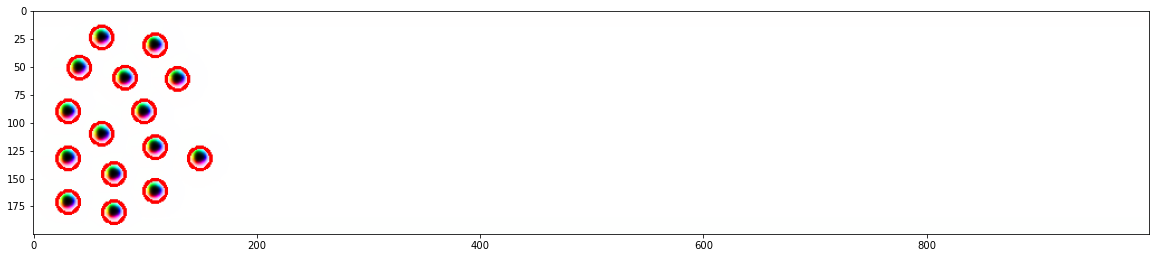

Getting frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:07<00:00, 107.92it/s]


In [3]:
# copy of data so that the original is unchanged
data_1 = data.copy()

# show which frames we will be working on
print('**Particles used for training**')
show_tracked(data_1, directory)

# format data so that it is in the format (frame, next_frame)
frames = get_frames(data_1)

# data in columns ['frame', 'next_frame']
df = pd.DataFrame(columns=['frame', 'next_frame'])

for i in range(1, len(frames)):
    df = df.append({'frame': frames[i-1], 'next_frame': frames[i]}, ignore_index=True)

**Linear Regression**

In [6]:
from sklearn.linear_model import LinearRegression

# split data in training and testing
X_train, y_train, X_test, y_test = split(df, 0.2)

# fit linear regression
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

# evaluate linear regression
print('The model performance for X_train')
y_predict_train = evaluate(X_train, y_train, lin_model)

print('The model performance for X_test')
y_predict_test = evaluate(X_test, y_test, lin_model)

The model performance for X_train
--------------------------------------
RMSE is 3.416191282758604
R2 score is 0.9854093671582872


The model performance for X_test
--------------------------------------
RMSE is 5.964209454235747
R2 score is 0.8295229850253383




In [7]:
# prediction to dataframe
train_predict_df = get_predictions_df(y_predict_train)
test_predict_df = get_predictions_df(y_predict_test)

Prediction to dataframe: 100%|█████████████████████████████████████████████████████████████████████████████████████| 159/159 [00:02<00:00, 57.85it/s]


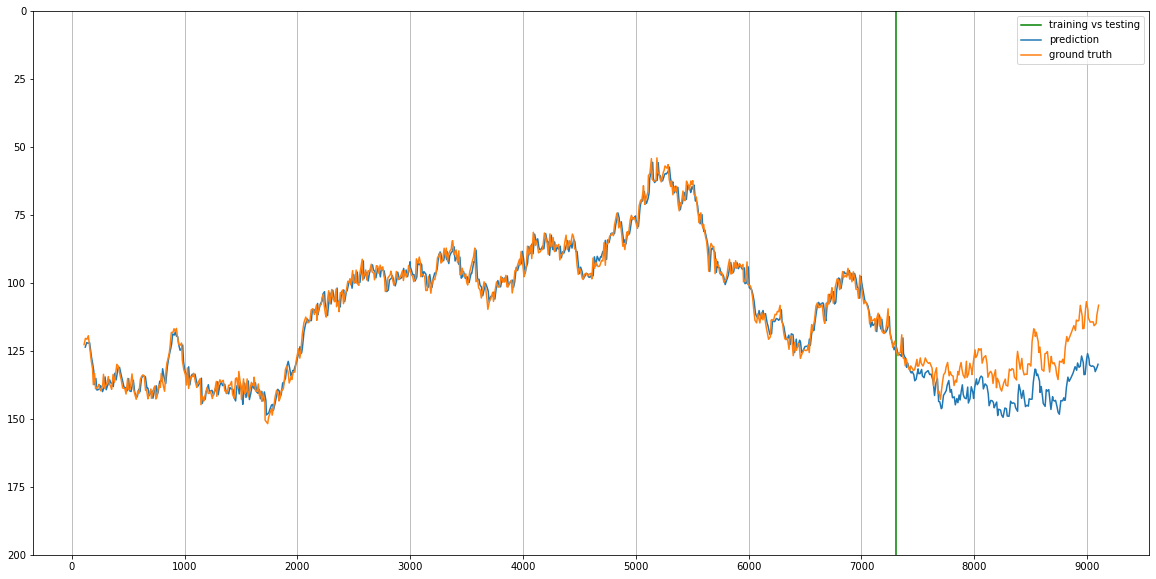

In [8]:
# plot prediction vs truth
plot_prediction(train_predict_df, test_predict_df, data, particle=8)

**Poly Regression**

In [12]:
degree = 3
poly_features = PolynomialFeatures(degree=degree)

# transform the features to higher degree features.
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.fit_transform(X_test)

# fit the transformed features to Linear Regression
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)

# model avaluation
print('The model performance for X_train')
y_predict_train = evaluate(X_train_poly, y_train, poly_model)

print('The model performance for X_test')
y_predict_test = evaluate(X_test_poly, y_test, poly_model)

The model performance for X_train
--------------------------------------
RMSE is 4.230612009111436e-08
R2 score is 1.0


The model performance for X_test
--------------------------------------
RMSE is 716.1183356030466
R2 score is -1186.4234959558164




In [13]:
# prediction to dataframe
train_predict_df = get_predictions_df(y_predict_train)
test_predict_df = get_predictions_df(y_predict_test)

Prediction to dataframe: 100%|█████████████████████████████████████████████████████████████████████████████████████| 159/159 [00:02<00:00, 58.40it/s]


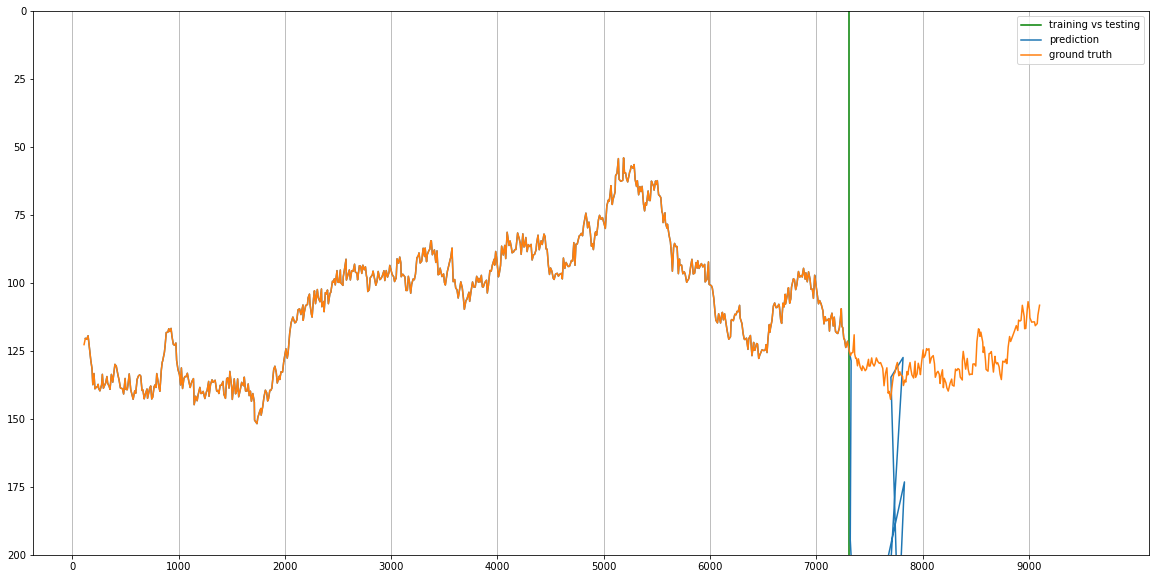

In [14]:
# plot prediction vs truth
plot_prediction(train_predict_df, test_predict_df, data, particle=8)

## Experiment 2: how many frames in the future can I predict given one frame?

**Try to predict n frames in the future**

In [21]:
n = 5

# data in format (frame, next n frames)
dfn = pd.DataFrame(columns=['X', 'y'])

for i in range(n, len(frames)):
    target = []
    for j in range(n-1, -1, -1):
        target = target + frames[i-j]
    dfn = dfn.append({'X': frames[i-2], 'y': target}, ignore_index=True)

In [22]:
X_train, y_train, X_test, y_test = split(dfn, 0.2)

**Linear Regression**

In [23]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

LinearRegression()

In [24]:
print('The model performance for X_train')
y_predict_train = evaluate(X_train, y_train)

print('The model performance for X_test')
y_predict_test = evaluate(X_test, y_test)

The model performance for X_train
--------------------------------------
RMSE is 3.3078562701778664
R2 score is 0.9858660451377333


The model performance for X_test
--------------------------------------
RMSE is 6.3404056232005095
R2 score is 0.8420766420553342




**Poly regression**

In [25]:
create_polynomial_regression_model(2)

The model performance for the training set
-------------------------------------------
RMSE of training set is 1.2712673881880174
R2 score of training set is 0.9979371011566074


The model performance for the test set
-------------------------------------------
RMSE of test set is 147.95375364893425
R2 score of test set is -79.4920119365813


In [26]:
create_polynomial_regression_model(3)

The model performance for the training set
-------------------------------------------
RMSE of training set is 2.2904825149409633e-08
R2 score of training set is 1.0


The model performance for the test set
-------------------------------------------
RMSE of test set is 613.001485288703
R2 score of test set is -1109.7433838074228


We can see that if we set the target as the next n frames and train with samples of the form (frame, next n frames), the model performs quite well with a linear model, but e polynomial one overfits the training data. This is the same result as the case in which we try to predict only one frame. But we are more interested in predicting multiple frames in the future give a sample of the form (frame, next frames), which we will look at in the next section.

## Experiment 3: how are the results affected if I try to predict on using my prediction as input data? For how many rounds can this be accurate enough?

**Try to predict n times**

In [27]:
n = 500

# data in columns format (frame, next frame, next next frame, ...)
df_n_rounds = pd.DataFrame(columns=['X', 'y_1'])

for i in range(1, n):
    df_n_rounds['y_' + str(i+1)] = ''

for i in range(n+1):
    col = []
    for j in range(i, len(frames)-n+i):
        col.append(frames[j])
    if i == 0:
        df_n_rounds['X'] = col
    else:
        df_n_rounds['y_' + str(i)] = col

In [28]:
X_train, y_train, X_test, y_test = split(df_n_rounds, 0.2)

We train the model in the first two columns.

**Linear Regression**

In [29]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

LinearRegression()

In [30]:
print('The model performance for X_train')
y_predict_train = evaluate(X_train, y_train)

print('The model performance for X_test')
y_predict_test = evaluate(X_test, y_test)

The model performance for X_train
--------------------------------------
RMSE is 2.807201739790159
R2 score is 0.9680384466512048


The model performance for X_test
--------------------------------------
RMSE is 27.017469910967346
R2 score is -4.103789321119496




The result is as the case of linear regression, as expected. We will not look at polynomial regression as it clearly overfits.

In [31]:
y_i_predict =  lin_model.predict(X_train+X_test)
for i in range(1, n):
    print("The model performance for y_{} -> y_{}".format(i, i+1))
    evaluate(df_n_rounds['y_' + str(i+1)].tolist(), y_i_predict)

The model performance for y_1 -> y_2
--------------------------------------
RMSE is 15.817276091095305
R2 score is 0.9744601487017877


The model performance for y_2 -> y_3
--------------------------------------
RMSE is 23.531839825477135
R2 score is 0.9625784842195916


The model performance for y_3 -> y_4
--------------------------------------
RMSE is 31.26389519263788
R2 score is 0.9512321902249118


The model performance for y_4 -> y_5
--------------------------------------
RMSE is 39.00639590990219
R2 score is 0.9399239638022062


The model performance for y_5 -> y_6
--------------------------------------
RMSE is 46.744185972274465
R2 score is 0.9272591233276739


The model performance for y_6 -> y_7
--------------------------------------
RMSE is 54.48862465530715
R2 score is 0.9155919087638635


The model performance for y_7 -> y_8
--------------------------------------
RMSE is 62.228252751194766
R2 score is 0.9035094155770035


The model performance for y_8 -> y_9
--------------

In [32]:
# get predictions from j to j+n

j = 0

truth = df_n_rounds.iloc[j].values.tolist()  # this are the n frames starting from frame 0 (ground truth)

predictions = []
predictions.append(X_train[j])

y_i_predict = lin_model.predict(X_train+X_test)
predictions.append(y_i_predict[j].tolist())

for i in range(1, n):
    y_i_predict = lin_model.predict(y_i_predict)
    predictions.append(y_i_predict[j].tolist())

In [33]:
# place data in df

truth_df = get_predictions_df(truth)
pred_df = get_predictions_df(predictions)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 501/501 [00:08<00:00, 60.48it/s]


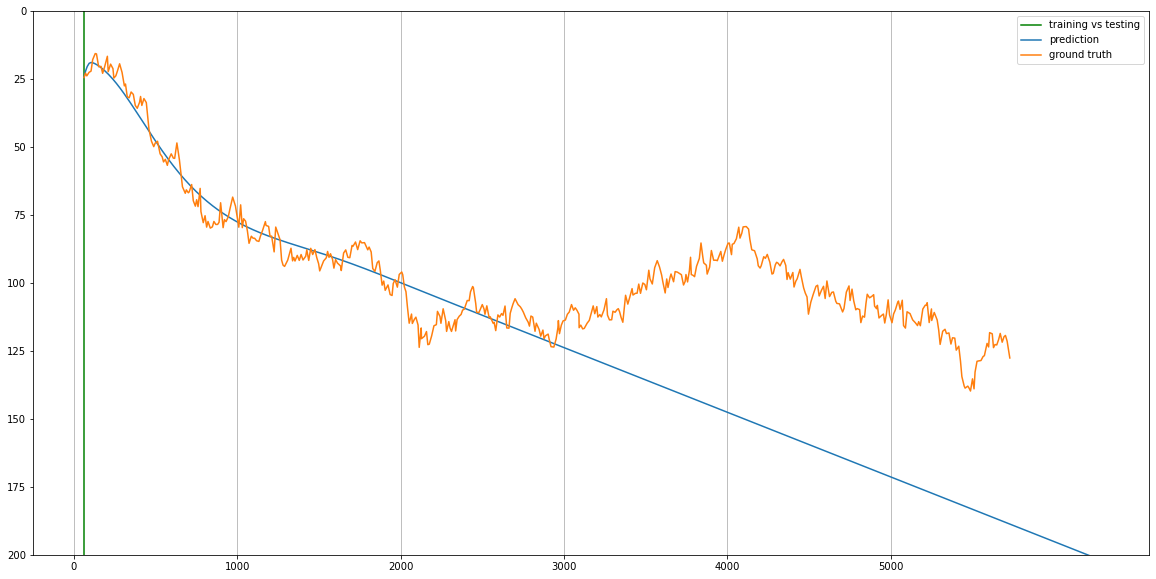

In [34]:
plot_prediction(pred_df[pred_df['frame'] == 0], pred_df[pred_df['frame'] > 0], truth_df, particle=0)

We can see that this really underfits the data, but with a more complex model we would overfit.

## Analyse behaviour of subsets of skyrmions (only cosider the ones in the top half, bottom half, centre)

In [35]:
# top qurter
top = data.copy()
# bottom qurter
bottom = data.copy()
# middle quarter
centre = data.copy()

# drop particles that do not start in the top/bottom/centre of the 
# construct top
particles_to_keep = []
for index, row in data[data['frame'] == 0].iterrows():
    if row['y'] < max(data['y']) / 4:
        particles_to_keep.append(row['particle'])
        
for index, row in tqdm(top.iterrows()):
    if row['particle'] not in particles_to_keep:
        top = top.drop(index)

# construct bottom
particles_to_keep = []
for index, row in data[data['frame'] == 0].iterrows():
    if row['y'] > 3 * (max(data['y']) / 4):
        particles_to_keep.append(row['particle'])
        
for index, row in tqdm(bottom.iterrows()):
    if row['particle'] not in particles_to_keep:
        bottom = bottom.drop(index)

# construct centre
particles_to_keep = []
for index, row in data[data['frame'] == 0].iterrows():
    if row['y'] > 3 * (max(data['y']) / 8) and row['y'] < 5 * (max(data['y']) / 8):
        particles_to_keep.append(row['particle'])
        
for index, row in tqdm(centre.iterrows()):
    if row['particle'] not in particles_to_keep:
        centre = centre.drop(index)

12000it [00:05, 2015.10it/s]
12000it [00:05, 2365.43it/s]
12000it [00:05, 2142.71it/s]


**Analyse Top**

In [36]:
top.describe()

y            x       frame     particle
count  1600.000000  1600.000000  1600.00000  1600.000000
mean     91.646874  4534.113318   399.50000     0.500000
std      35.653440  2577.574292   231.01213     0.500156
min      15.109391    61.809992     0.00000     0.000000
25%      69.341467  2294.652841   199.75000     0.000000
50%      87.821167  4522.438422   399.50000     0.500000
75%     113.762225  6771.479529   599.25000     1.000000
max     177.842924  9030.630412   799.00000     1.000000

Tracked particles on first frame


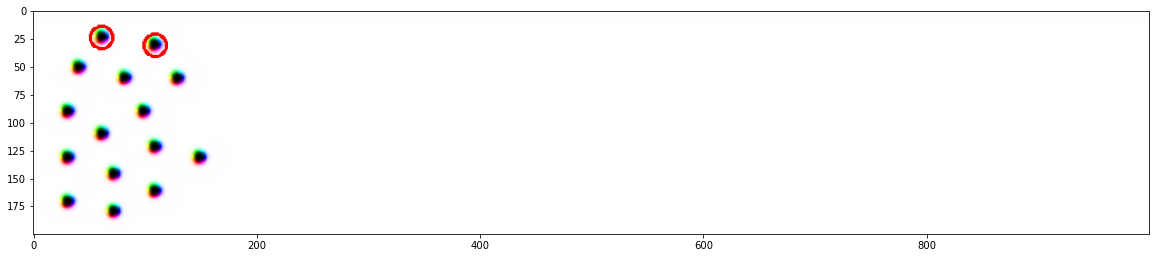

In [37]:
show_tracked(top)

The skyrmions move throughout the entire y-axis. Of course their behaviour is influences by other skyrmions in the ensamble as well. But it seems like there is no tendency of skyrmoins remaining at the top when startin there. This can be observed in both the plot and the tbale above (mean is close to 100).

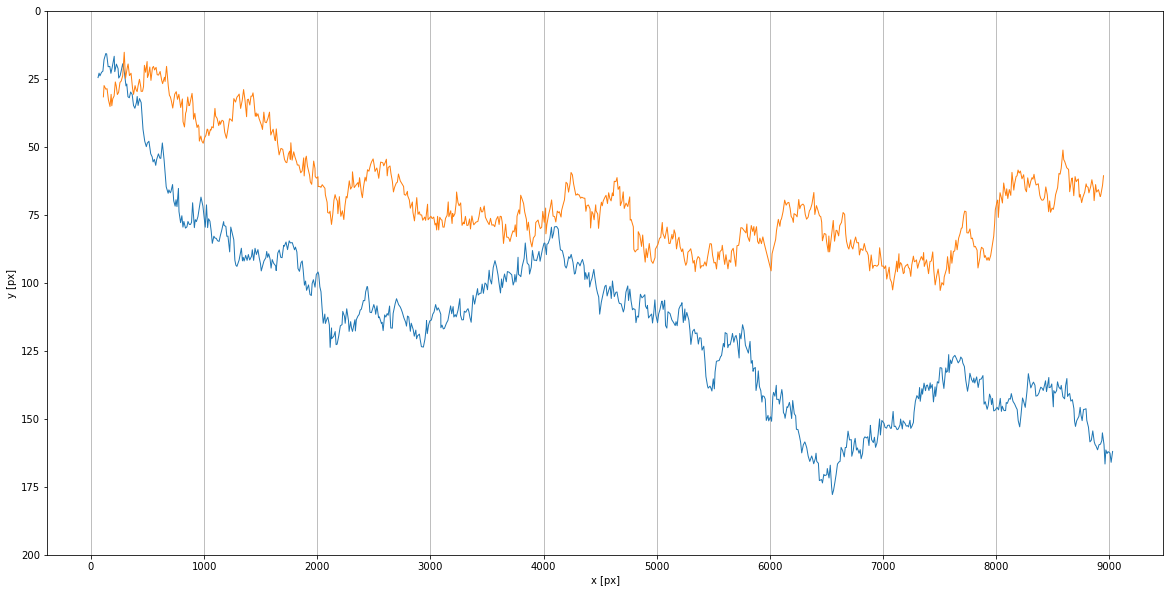

In [38]:
plt.figure(figsize=(20, 10))
plt.grid(True, axis='x')
plt.xticks(np.arange(0, max(top['x'])+1, 1000.0))
plt.ylim(0, 200)
tp.plot_traj(top)

**Analyse Bottom**

In [39]:
bottom.describe()

y            x       frame     particle
count  3200.000000  3200.000000  3200.00000  3200.000000
mean    137.680046  4392.376980   399.50000    12.500000
std      41.892480  2512.624307   230.97602     1.118209
min      15.437867    31.206029     0.00000    11.000000
25%     111.917488  2215.992326   199.75000    11.750000
50%     155.502694  4384.494667   399.50000    12.500000
75%     167.014834  6556.735970   599.25000    13.250000
max     188.012413  8909.539660   799.00000    14.000000

Tracked particles on first frame


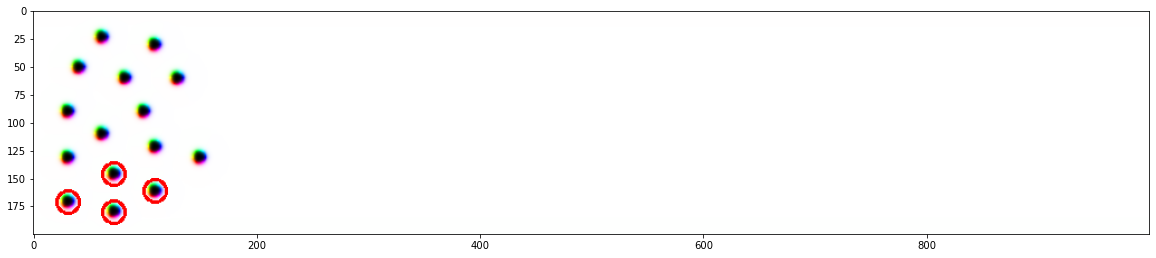

In [40]:
show_tracked(bottom)

Here skyrmions seem to behave a bit differently from the ones in the top quarter as 3 of the 4 skyrmions mostly stay in the bottom half, hence it seems like the strongest interactions are among the skyrmoins in the sub-ensable rather than with all the further ones as well.

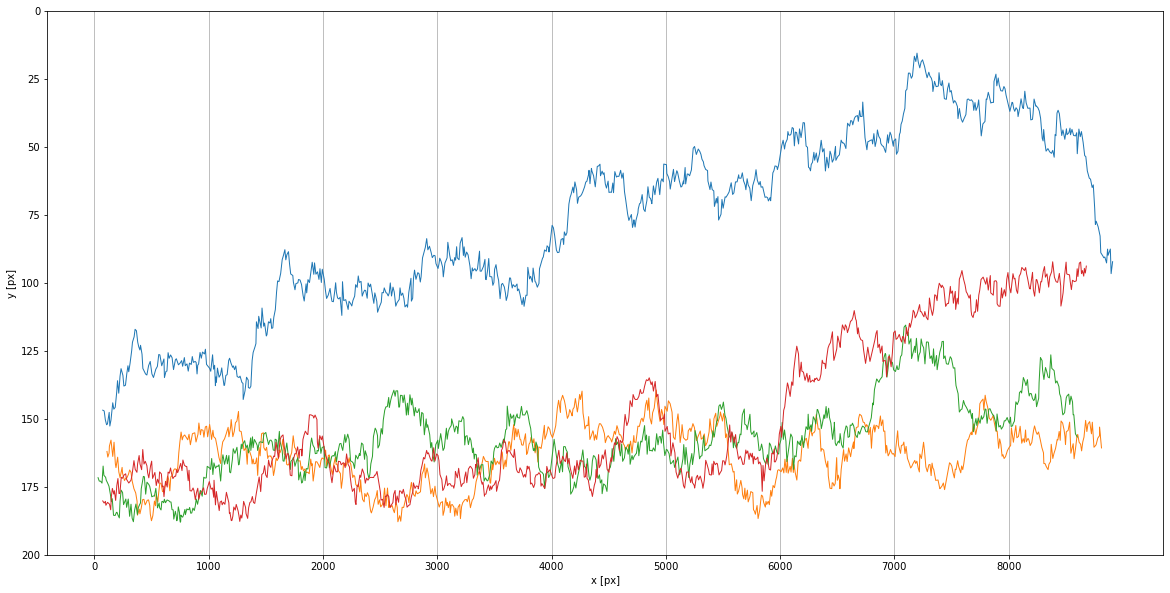

In [41]:
plt.figure(figsize=(20, 10))
plt.grid(True, axis='x')
plt.xticks(np.arange(0, max(bottom['x'])+1, 1000.0))
plt.ylim(0, 200)
tp.plot_traj(bottom)

**Analyse Centre**

In [42]:
centre.describe()

y            x        frame     particle
count  2400.000000  2400.000000  2400.000000  2400.000000
mean    124.494654  4384.496409   399.500000     6.000000
std      38.239116  2514.763499   230.988055     0.816667
min      20.971020    31.088248     0.000000     5.000000
25%      96.921945  2203.571816   199.750000     5.000000
50%     126.848526  4355.232439   399.500000     6.000000
75%     156.733882  6549.055436   599.250000     7.000000
max     186.792020  8844.332414   799.000000     7.000000

Tracked particles on first frame


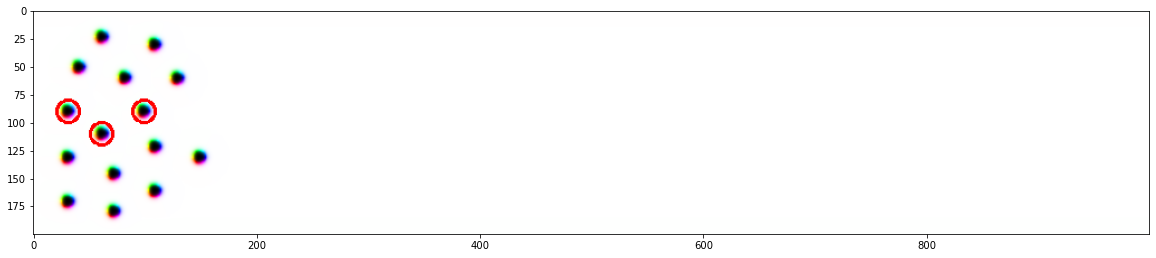

In [43]:
show_tracked(centre)

The middle quarter is quite interesting as one skyrmion seems to almost move independently of the other two, but the lower ones seem to be moving almost together in the second half of the plot.

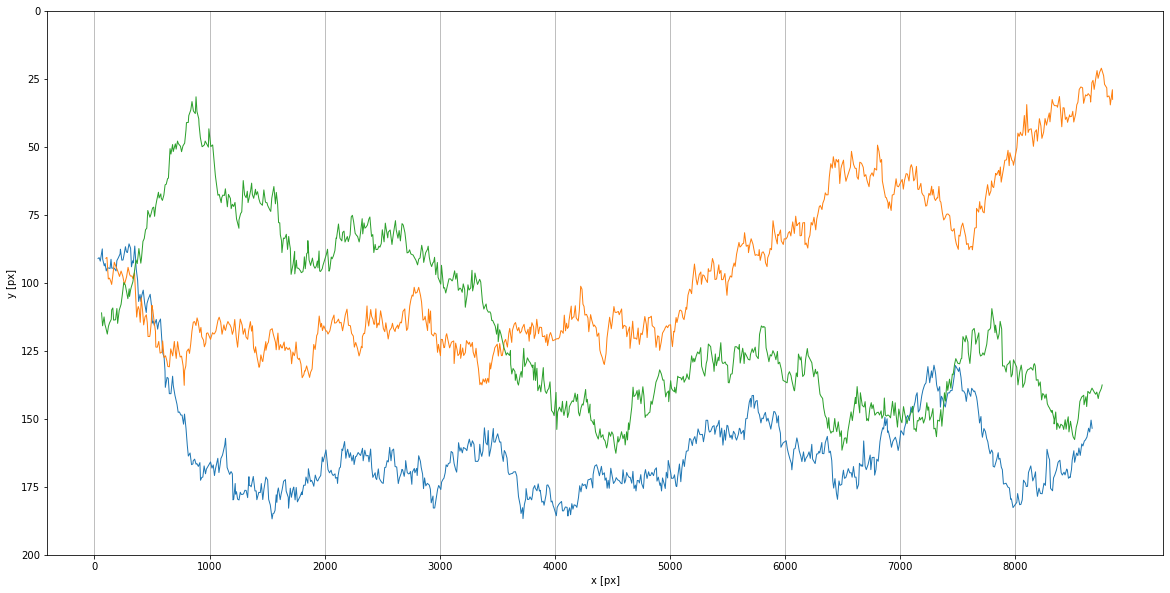

In [44]:
plt.figure(figsize=(20, 10))
plt.grid(True, axis='x')
plt.xticks(np.arange(0, max(centre['x'])+1, 1000.0))
plt.ylim(0, 200)
tp.plot_traj(centre)

## Experiment 4: linear regression with randomly chosen half of the particles and predict others

In [45]:
# place prediction in df given ids list

def get_pred_df_idx(y_pred, ids):
    predict_df = pd.DataFrame(columns=['x', 'y', 'frame', 'particle'])

    for i in tqdm(range(len(y_pred))):
        for j, k in zip(ids, range(0, len(y_pred[i]), 2)):
            predict_df = predict_df.append({'x': y_pred[i][k], 'y':y_pred[i][k+1], 'frame': i, 'particle': j}, ignore_index=True)

    return predict_df

In [46]:
def plot_pred(pred_df, ids, truth=True):
    plt.figure(figsize=(20, 10))
    plt.grid(True, axis='x')
    plt.xticks(np.arange(0, max(data['x'])+1, 1000.0))
    plt.ylim(0, 200)
    plt.gca().invert_yaxis()

    for particle in ids:
        x = pred_df[pred_df['particle'] == particle]['x']
        y = pred_df[pred_df['particle'] == particle]['y']
        plt.plot(x, y, label='train', color='b')
        if truth:
            plt.plot(data[data['particle'] == particle]['x'], data[data['particle'] == particle]['y'], label='ground truth', color='r')

    plt.legend()

**Let's use half of the particles to train and the rest to test**

In [112]:
no_skyrmions = data[data['frame'] == 0].shape[0]

ids = list(range(0, no_skyrmions))

train_ids = random.sample(ids, k=7)
ids = [x for x in ids if x not in train_ids]

test_ids = random.sample(ids, k=7)

train_data = data[data['particle'].isin(train_ids)]
test_data = data[data['particle'].isin(test_ids)]

**Train data**
Tracked particles on first frame


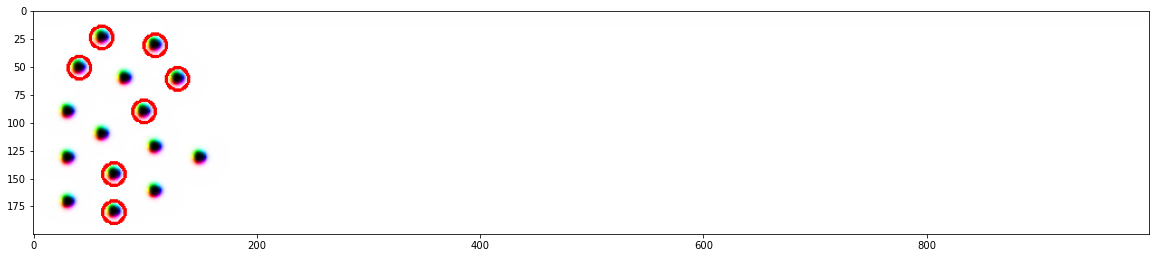

**Test data**
Tracked particles on first frame


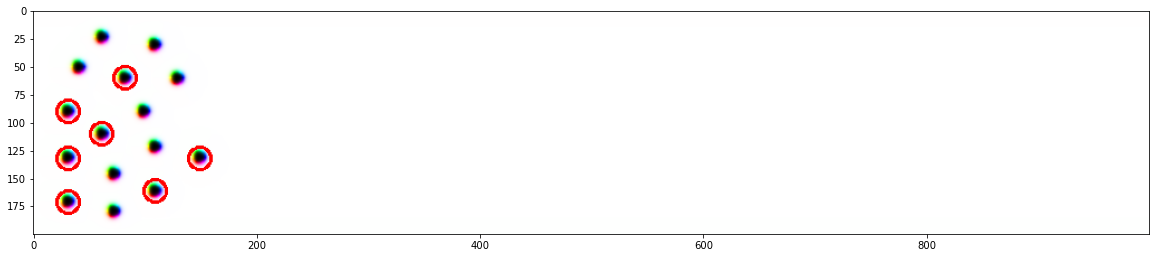

In [113]:
print('**Train data**')
show_tracked(train_data)
print('**Test data**')
show_tracked(test_data)

In [114]:
train_frames = get_frames(train_data)
test_frames = get_frames(test_data)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:04<00:00, 169.53it/s]


In [115]:
# data in columns ['frame', 'next_frame']
train_df = pd.DataFrame(columns=['frame', 'next_frame'])
test_df = pd.DataFrame(columns=['frame', 'next_frame'])

for i in range(1, len(train_frames)):
    train_df = train_df.append({'frame': train_frames[i-1], 'next_frame': train_frames[i]}, ignore_index=True)
    
for i in range(1, len(test_frames)):
    test_df = test_df.append({'frame': test_frames[i-1], 'next_frame': test_frames[i]}, ignore_index=True)
    
X_train = train_df['frame'].tolist()
y_train = train_df['next_frame'].tolist()
X_test = test_df['frame'].tolist()
y_test = test_df['next_frame'].tolist()

In [116]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

LinearRegression()

In [117]:
print('The model performance for X_train')
y_predict_train = evaluate(X_train, y_train)

print('The model performance for X_test')
y_predict_test = evaluate(X_test, y_test)

The model performance for X_train
--------------------------------------
RMSE is 3.5016151526099715
R2 score is 0.9901507946311845


The model performance for X_test
--------------------------------------
RMSE is 11.463028195400316
R2 score is 0.8802831424753722




In [118]:
pred_train_df = get_pred_df_idx(y_predict_train, train_ids)
pred_test_df = get_pred_df_idx(y_predict_test, test_ids)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 799/799 [00:09<00:00, 80.03it/s]


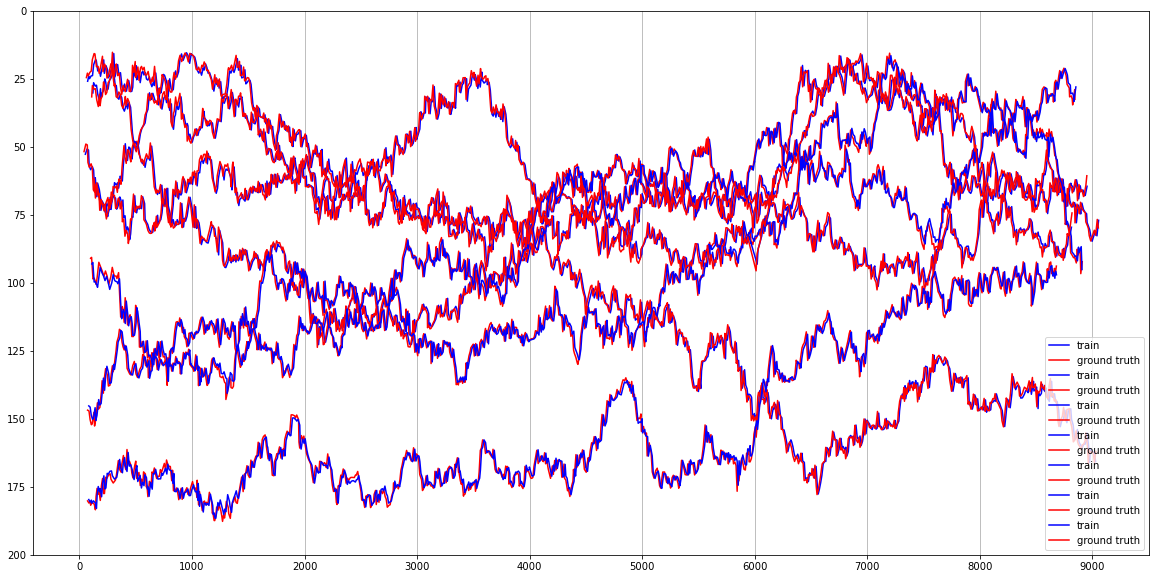

In [119]:
plot_pred(pred_train_df, train_ids)

In [120]:
print(test_ids)

[13, 7, 3, 12, 10, 5, 9]


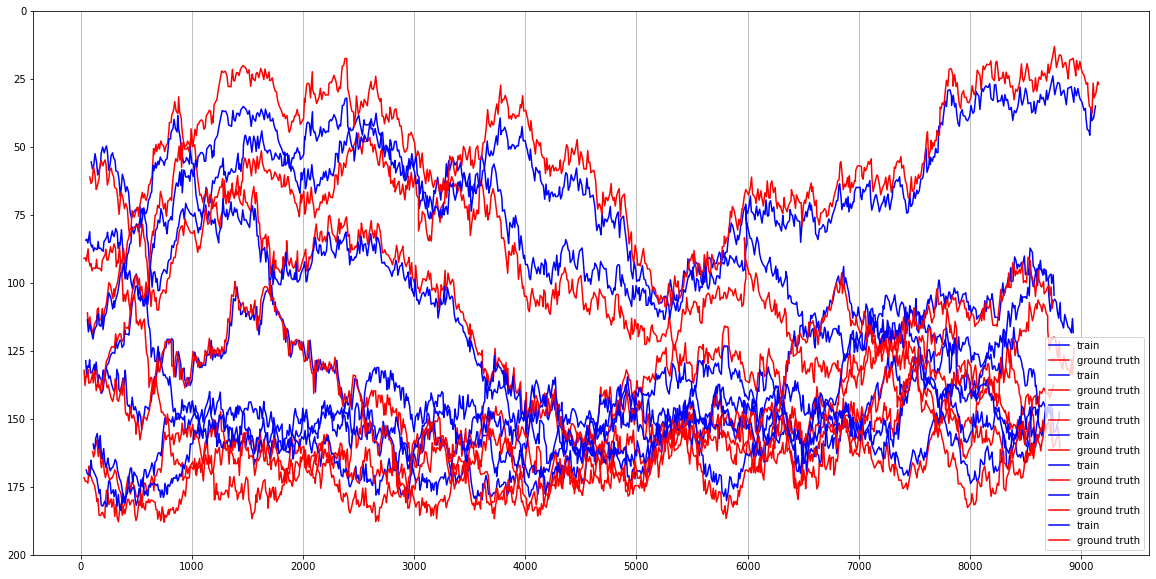

In [123]:
plot_pred(pred_test_df, test_ids)

This approach is not good as it requires the training and testing sets to contain the same number of skyrmions, but what if I wanna train with 60% and test with 40%? Also if the number of skyrmions is odd, one skyrmion will be left out.

## Experiment 5: linear regression with top half of the particles and predict others and vice versa

**Select the top half for linear regression and bottom for testing**

In [56]:
train_ids = data[data['frame'] == 0].nsmallest(7, 'y')['particle'].tolist()
test_ids = data[data['frame'] == 0].nlargest(7, 'y')['particle'].tolist()

train_data = data[data['particle'].isin(train_ids)]
test_data = data[data['particle'].isin(test_ids)]

**Train data**
Tracked particles on first frame


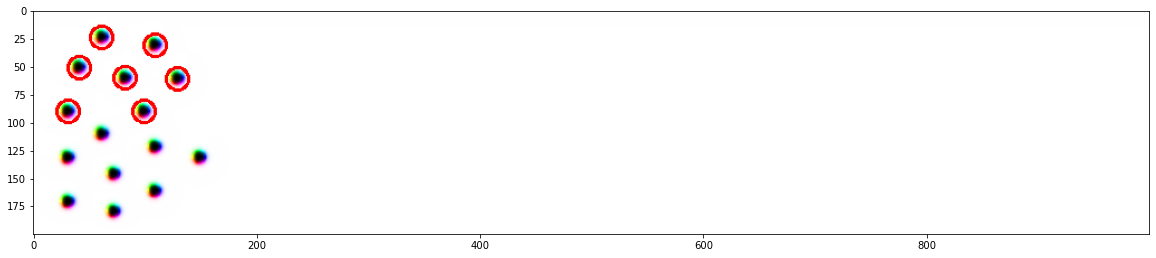

**Test data**
Tracked particles on first frame


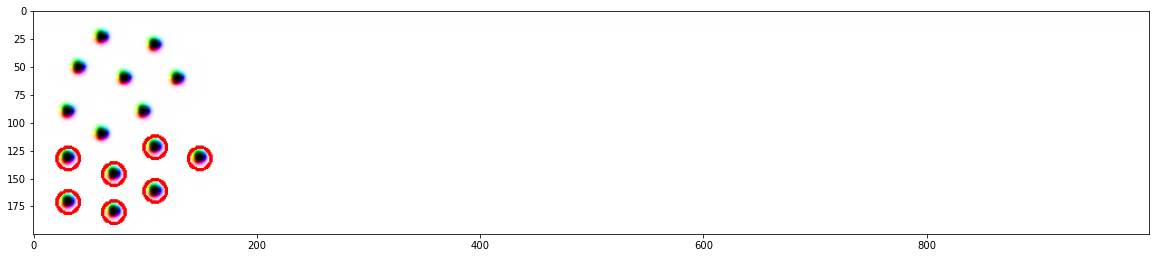

In [57]:
print('**Train data**')
show_tracked(train_data)
print('**Test data**')
show_tracked(test_data)

In [58]:
train_frames = get_frames(train_data)
test_frames = get_frames(test_data)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:03<00:00, 244.73it/s]


In [59]:
# data in columns ['frame', 'next_frame']
train_df = pd.DataFrame(columns=['frame', 'next_frame'])
test_df = pd.DataFrame(columns=['frame', 'next_frame'])

for i in range(1, len(train_frames)):
    train_df = train_df.append({'frame': train_frames[i-1], 'next_frame': train_frames[i]}, ignore_index=True)
    
for i in range(1, len(test_frames)):
    test_df = test_df.append({'frame': test_frames[i-1], 'next_frame': test_frames[i]}, ignore_index=True)
    
X_train = train_df['frame'].tolist()
y_train = train_df['next_frame'].tolist()
X_test = test_df['frame'].tolist()
y_test = test_df['next_frame'].tolist()

In [60]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

LinearRegression()

In [61]:
print('The model performance for X_train')
y_predict_train = evaluate(X_train, y_train)

print('The model performance for X_test')
y_predict_test = evaluate(X_test, y_test)

The model performance for X_train
--------------------------------------
RMSE is 3.5175656804393065
R2 score is 0.9889956708566536


The model performance for X_test
--------------------------------------
RMSE is 12.203441595419633
R2 score is 0.8298237501520946




In [62]:
pred_train_df = get_pred_df_idx(y_predict_train, train_ids)
pred_test_df = get_pred_df_idx(y_predict_test, test_ids)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 799/799 [00:06<00:00, 117.23it/s]


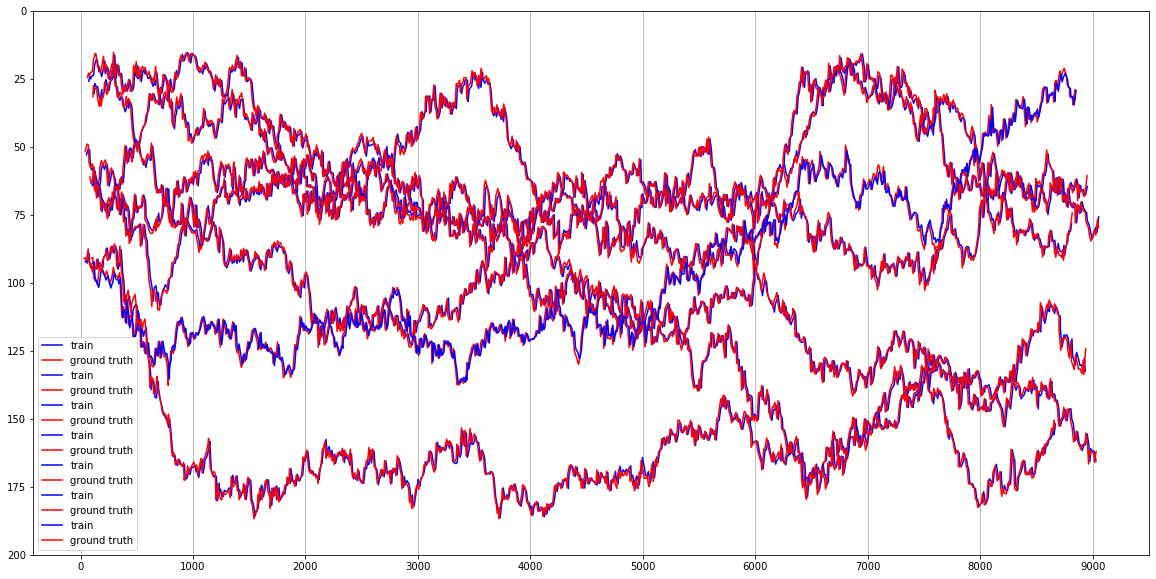

In [63]:
plot_pred(pred_train_df, train_ids)

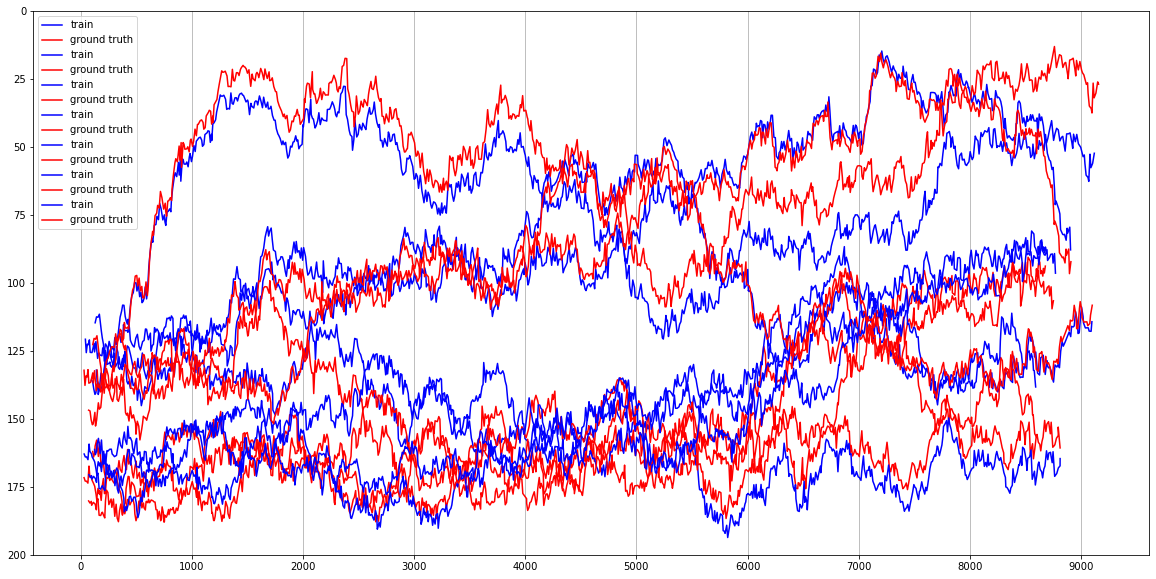

In [64]:
plot_pred(pred_test_df, test_ids)

**Select the top half for linear regrassion and bottom for testing**

In [65]:
train_ids = data[data['frame'] == 0].nlargest(7, 'y')['particle'].tolist()
test_ids = data[data['frame'] == 0].nsmallest(7, 'y')['particle'].tolist()

train_data = data[data['particle'].isin(train_ids)]
test_data = data[data['particle'].isin(test_ids)]

**Train data**
Tracked particles on first frame


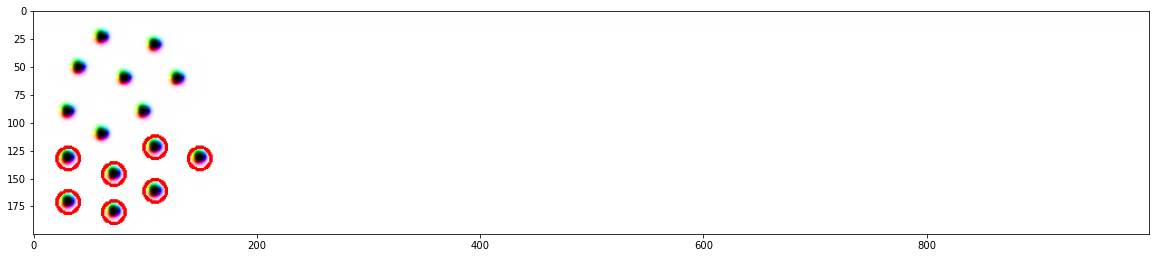

**Test data**
Tracked particles on first frame


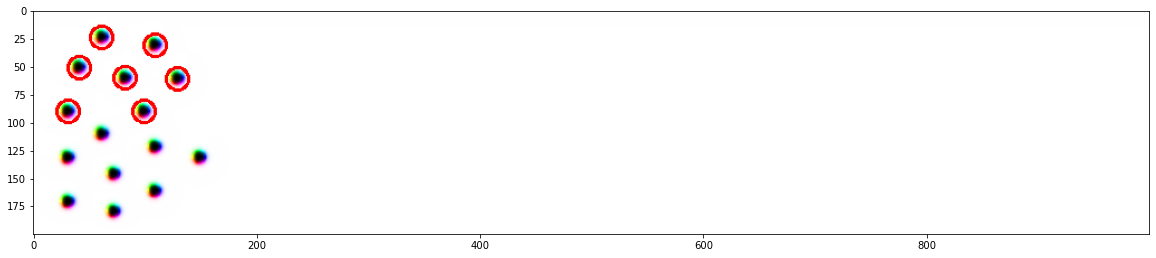

In [66]:
print('**Train data**')
show_tracked(train_data)
print('**Test data**')
show_tracked(test_data)

In [67]:
train_frames = get_frames(train_data)
test_frames = get_frames(test_data)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:03<00:00, 242.15it/s]


In [68]:
# data in columns ['frame', 'next_frame']
train_df = pd.DataFrame(columns=['frame', 'next_frame'])
test_df = pd.DataFrame(columns=['frame', 'next_frame'])

for i in range(1, len(train_frames)):
    train_df = train_df.append({'frame': train_frames[i-1], 'next_frame': train_frames[i]}, ignore_index=True)
    
for i in range(1, len(test_frames)):
    test_df = test_df.append({'frame': test_frames[i-1], 'next_frame': test_frames[i]}, ignore_index=True)
    
X_train = train_df['frame'].tolist()
y_train = train_df['next_frame'].tolist()
X_test = test_df['frame'].tolist()
y_test = test_df['next_frame'].tolist()

In [69]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

LinearRegression()

In [70]:
print('The model performance for X_train')
y_predict_train = evaluate(X_train, y_train)

print('The model performance for X_test')
y_predict_test = evaluate(X_test, y_test)

The model performance for X_train
--------------------------------------
RMSE is 3.5031610859735456
R2 score is 0.984826908505804


The model performance for X_test
--------------------------------------
RMSE is 11.126207357629763
R2 score is 0.8536516336490817




In [71]:
pred_train_df = get_pred_df_idx(y_predict_train, train_ids)
pred_test_df = get_pred_df_idx(y_predict_test, test_ids)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 799/799 [00:06<00:00, 122.43it/s]


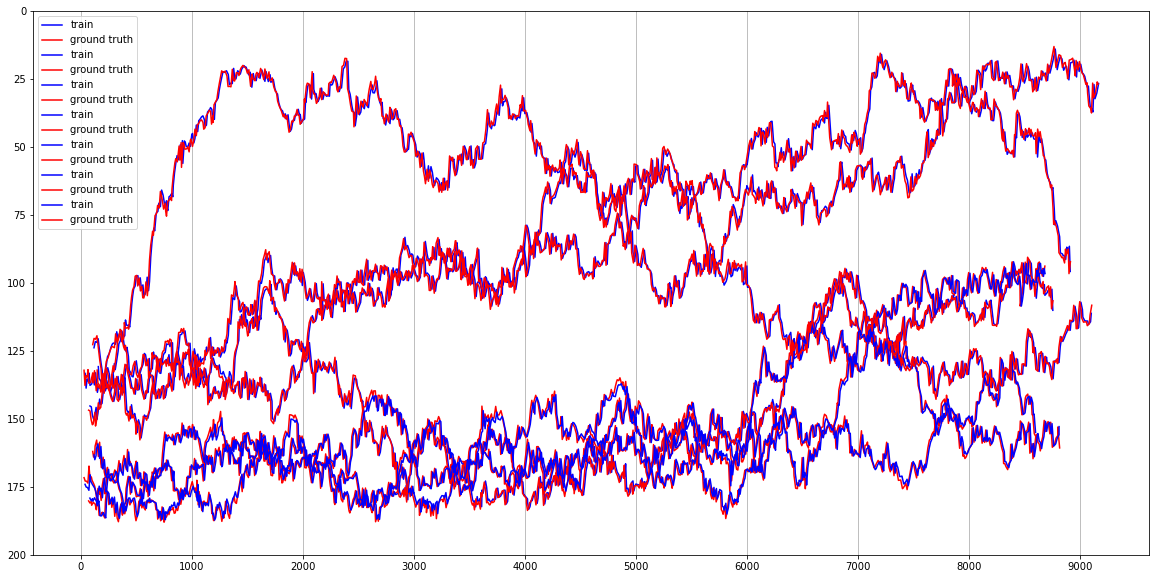

In [72]:
plot_pred(pred_train_df, train_ids)

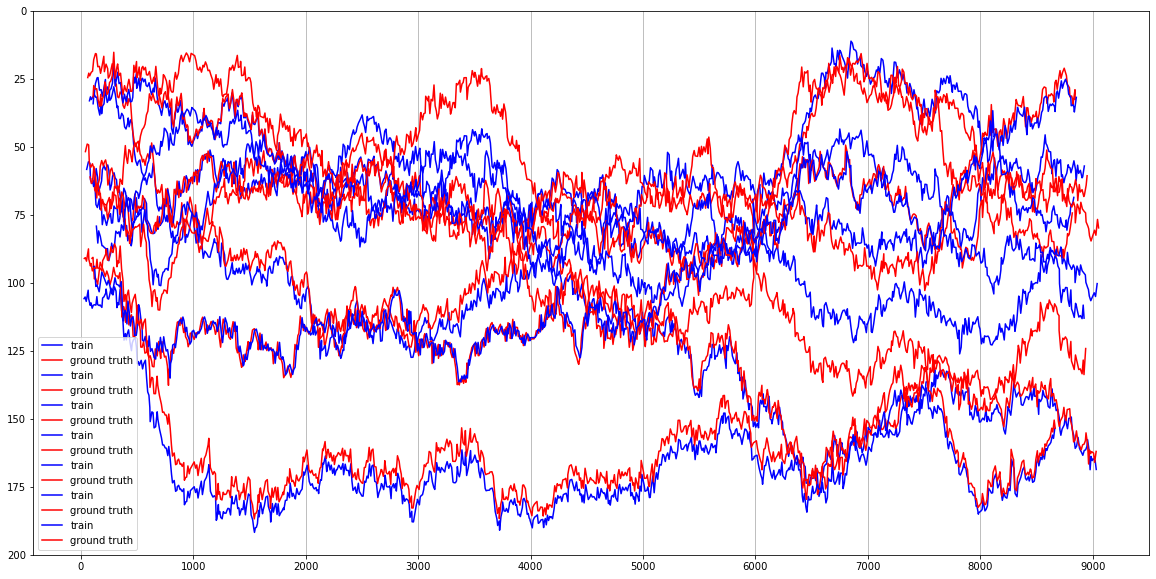

In [73]:
plot_pred(pred_test_df, test_ids)

## Experiment 6: train on 5 particles chosen at random and predict the other 10 (in two sets of 5)

In [74]:
ids = list(range(0, no_skyrmions))

train_ids = random.sample(ids, k=5)
ids = [x for x in ids if x not in train_ids]

test_1_ids = random.sample(ids, k=5)
ids = [x for x in ids if x not in test_1_ids]

test_2_ids = ids

In [75]:
train_data = data[data['particle'].isin(train_ids)]
test_1_data = data[data['particle'].isin(test_1_ids)]
test_2_data = data[data['particle'].isin(test_2_ids)]

**Train data**
Tracked particles on first frame


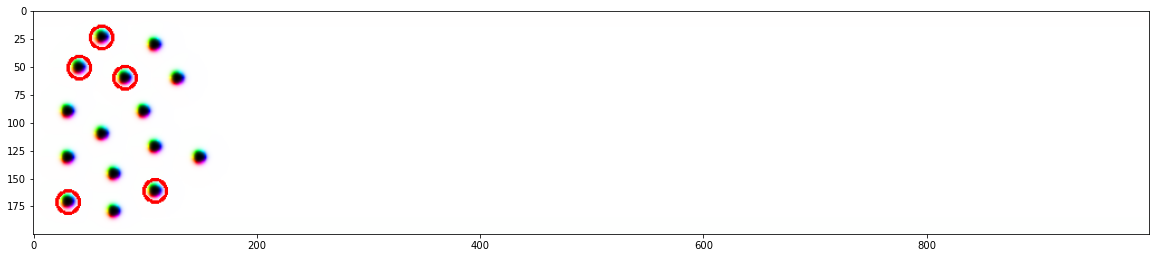

**Test data 1**
Tracked particles on first frame


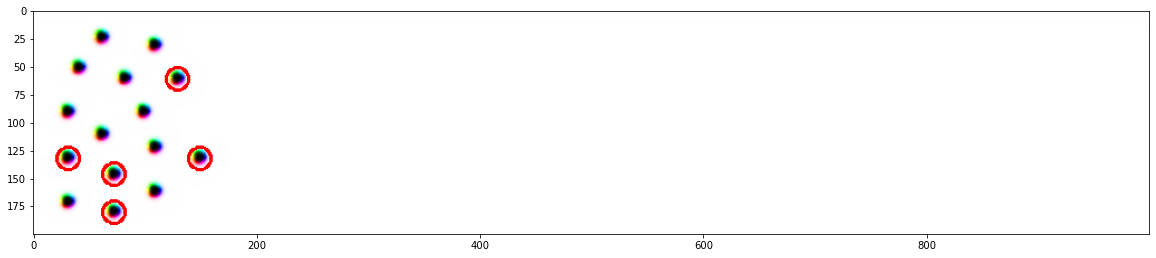

**Test data 2**
Tracked particles on first frame


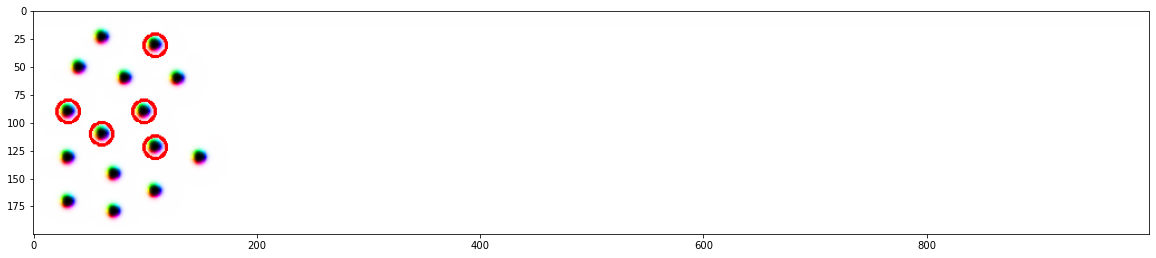

In [76]:
print('**Train data**')
show_tracked(train_data)
print('**Test data 1**')
show_tracked(test_1_data)
print('**Test data 2**')
show_tracked(test_2_data)

In [77]:
train_frames = get_frames(train_data)
test_1_frames = get_frames(test_1_data)
test_2_frames = get_frames(test_2_data)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 333.27it/s]


In [78]:
# data in columns ['frame', 'next_frame']
train_df = pd.DataFrame(columns=['frame', 'next_frame'])
test_1_df = pd.DataFrame(columns=['frame', 'next_frame'])
test_2_df = pd.DataFrame(columns=['frame', 'next_frame'])

for i in range(1, len(train_frames)):
    train_df = train_df.append({'frame': train_frames[i-1], 'next_frame': train_frames[i]}, ignore_index=True)
    
for i in range(1, len(test_1_frames)):
    test_1_df = test_1_df.append({'frame': test_1_frames[i-1], 'next_frame': test_1_frames[i]}, ignore_index=True)
    
for i in range(1, len(test_2_frames)):
    test_2_df = test_2_df.append({'frame': test_2_frames[i-1], 'next_frame': test_2_frames[i]}, ignore_index=True)
    
X_train = train_df['frame'].tolist()
y_train = train_df['next_frame'].tolist()
X_1_test = test_1_df['frame'].tolist()
y_1_test = test_1_df['next_frame'].tolist()
X_2_test = test_2_df['frame'].tolist()
y_2_test = test_2_df['next_frame'].tolist()

In [79]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

LinearRegression()

In [80]:
print("The model performance for training set")
train_pred = evaluate(X_train, y_train)

print("The model performance for testing set 1")
test_1_pred = evaluate(X_1_test, y_1_test)

print("The model performance for testing set 2")
test_2_pred = evaluate(X_2_test, y_2_test)

The model performance for training set
--------------------------------------
RMSE is 3.5038041905826263
R2 score is 0.9798991000471071


The model performance for testing set 1
--------------------------------------
RMSE is 7.174728259881839
R2 score is 0.9645918318773795


The model performance for testing set 2
--------------------------------------
RMSE is 11.482257777741097
R2 score is 0.8381347350922649




In [81]:
pred_train_df = get_pred_df_idx(train_pred, train_ids)
pred_test_1_df = get_pred_df_idx(test_1_pred, test_1_ids)
pred_test_2_df = get_pred_df_idx(test_2_pred, test_2_ids)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 799/799 [00:07<00:00, 109.56it/s]


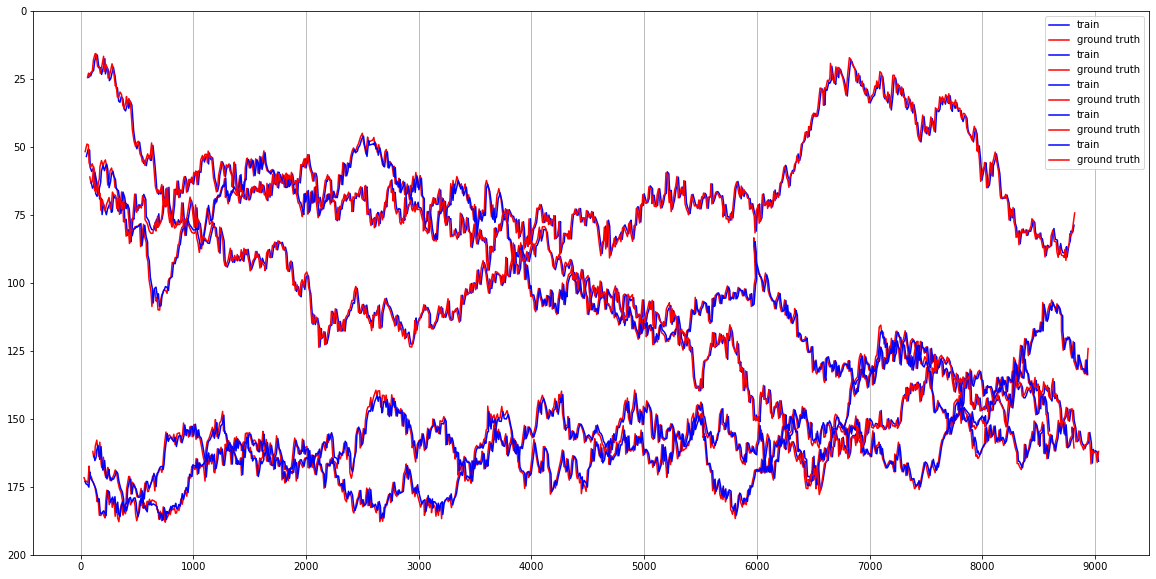

In [82]:
plot_pred(pred_train_df, train_ids)

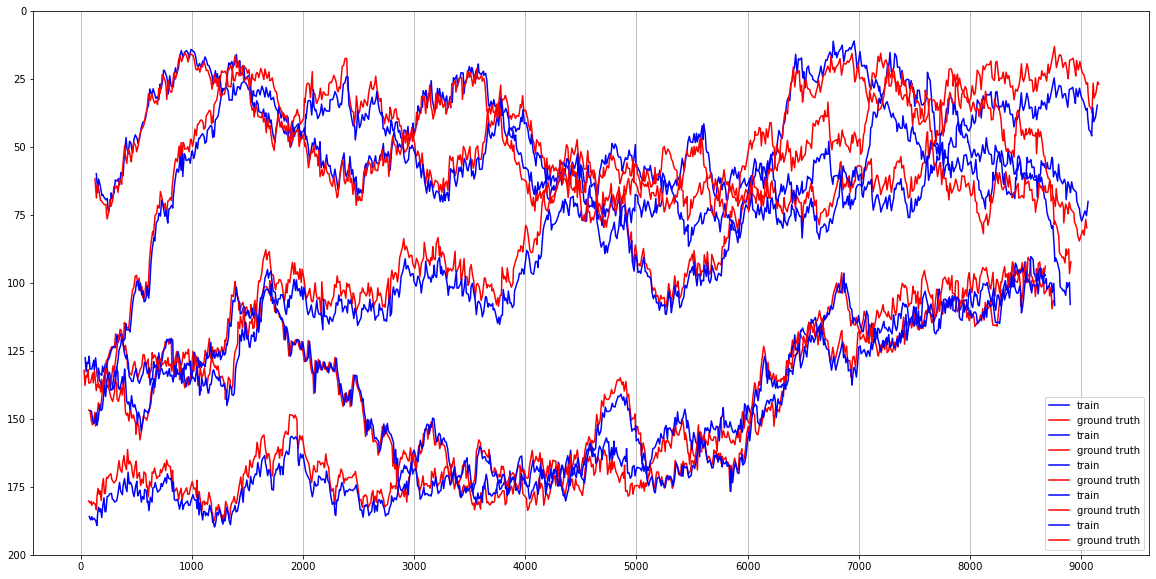

In [83]:
plot_pred(pred_test_1_df, test_1_ids)

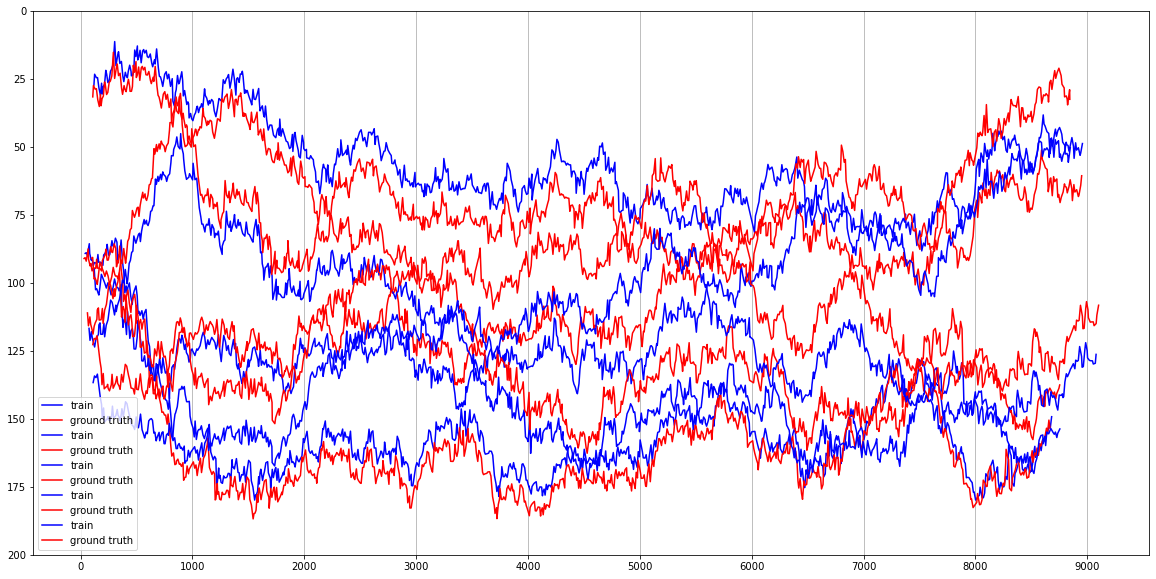

In [84]:
plot_pred(pred_test_2_df, test_2_ids)

## Experiment 7: train on 5 particles (top, centre, bottom) and predict the other 10 (in two sets of 5)

In [85]:
top_ids = data[data['frame'] == 0].nsmallest(5, 'y')['particle'].tolist()
bottom_ids = data[data['frame'] == 0].nlargest(5, 'y')['particle'].tolist()

ids = list(range(0, no_skyrmions))

centre_ids = [x for x in ids if x not in top_ids and x not in bottom_ids]

top_data = data[data['particle'].isin(top_ids)]
centre_data = data[data['particle'].isin(centre_ids)]
bottom_data = data[data['particle'].isin(bottom_ids)]

**Top data**
Tracked particles on first frame


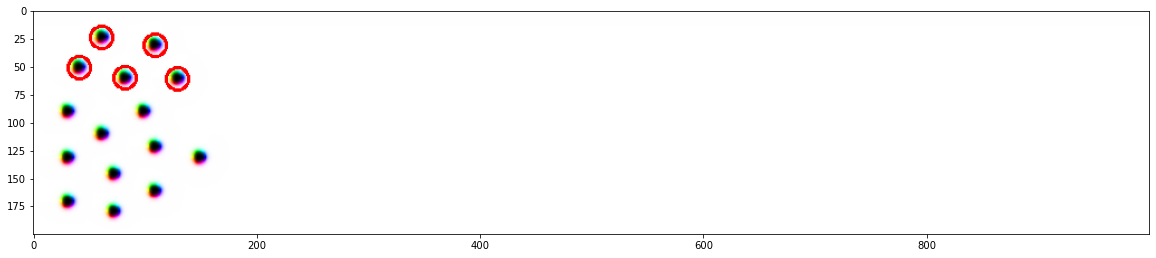

**Centre data**
Tracked particles on first frame


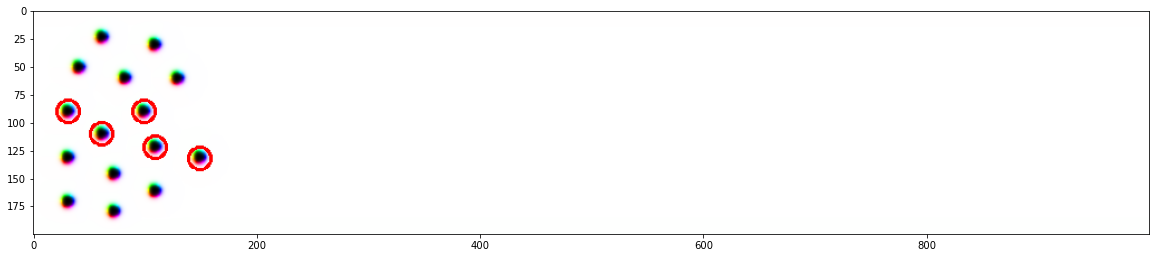

**Bottom data**
Tracked particles on first frame


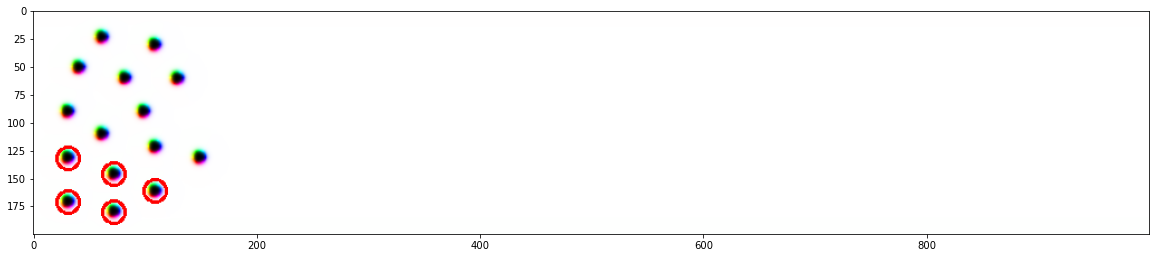

In [86]:
print('**Top data**')
show_tracked(top_data)
print('**Centre data**')
show_tracked(centre_data)
print('**Bottom data**')
show_tracked(bottom_data)

In [87]:
top_frames = get_frames(top_data)
centre_frames = get_frames(centre_data)
bottom_frames = get_frames(bottom_data)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:04<00:00, 196.99it/s]


In [88]:
# data in columns ['frame', 'next_frame']
top_df = pd.DataFrame(columns=['frame', 'next_frame'])
centre_df = pd.DataFrame(columns=['frame', 'next_frame'])
bottom_df = pd.DataFrame(columns=['frame', 'next_frame'])

for i in range(1, len(top_frames)):
    top_df = top_df.append({'frame': top_frames[i-1], 'next_frame': top_frames[i]}, ignore_index=True)
    
for i in range(1, len(centre_frames)):
    centre_df = centre_df.append({'frame': centre_frames[i-1], 'next_frame': centre_frames[i]}, ignore_index=True)

for i in range(1, len(bottom_frames)):
    bottom_df = bottom_df.append({'frame': bottom_frames[i-1], 'next_frame': bottom_frames[i]}, ignore_index=True)

X_top = top_df['frame'].tolist()
y_top = top_df['next_frame'].tolist()
X_centre = centre_df['frame'].tolist()
y_centre = centre_df['next_frame'].tolist()
X_bottom = bottom_df['frame'].tolist()
y_bottom = bottom_df['next_frame'].tolist()

**Train on top**

In [89]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()
lin_model.fit(X_top, y_top)

LinearRegression()

In [90]:
print("The model performance for training set (top)")
top_pred = evaluate(X_top, y_top)

print("The model performance for testing set (centre)")
centre_pred = evaluate(X_centre, y_centre)

print("The model performance for testing set (bottom)")
bottom_pred = evaluate(X_bottom, y_bottom)

The model performance for training set (top)
--------------------------------------
RMSE is 3.5384109586777464
R2 score is 0.9879133046376237


The model performance for testing set (centre)
--------------------------------------
RMSE is 8.366081179130328
R2 score is 0.9525343555656185


The model performance for testing set (bottom)
--------------------------------------
RMSE is 8.480387930206998
R2 score is 0.9032439896627181




In [91]:
pred_top_df = get_pred_df_idx(top_pred, top_ids)
pred_centre_df = get_pred_df_idx(centre_pred, centre_ids)
pred_bottom_df = get_pred_df_idx(bottom_pred, bottom_ids)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 799/799 [00:06<00:00, 123.09it/s]


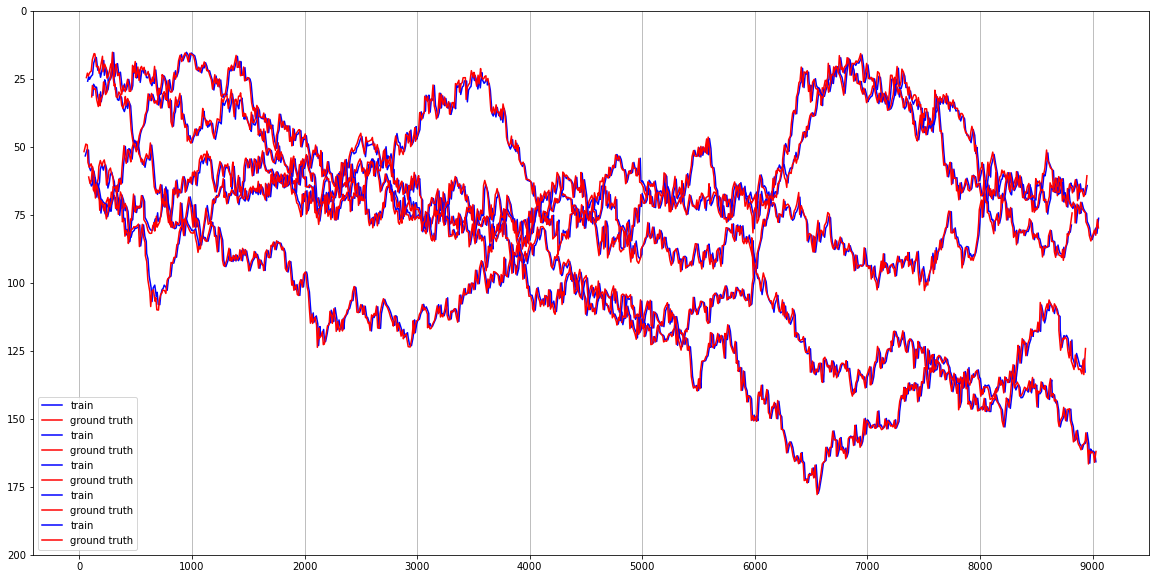

In [92]:
plot_pred(pred_top_df, top_ids)

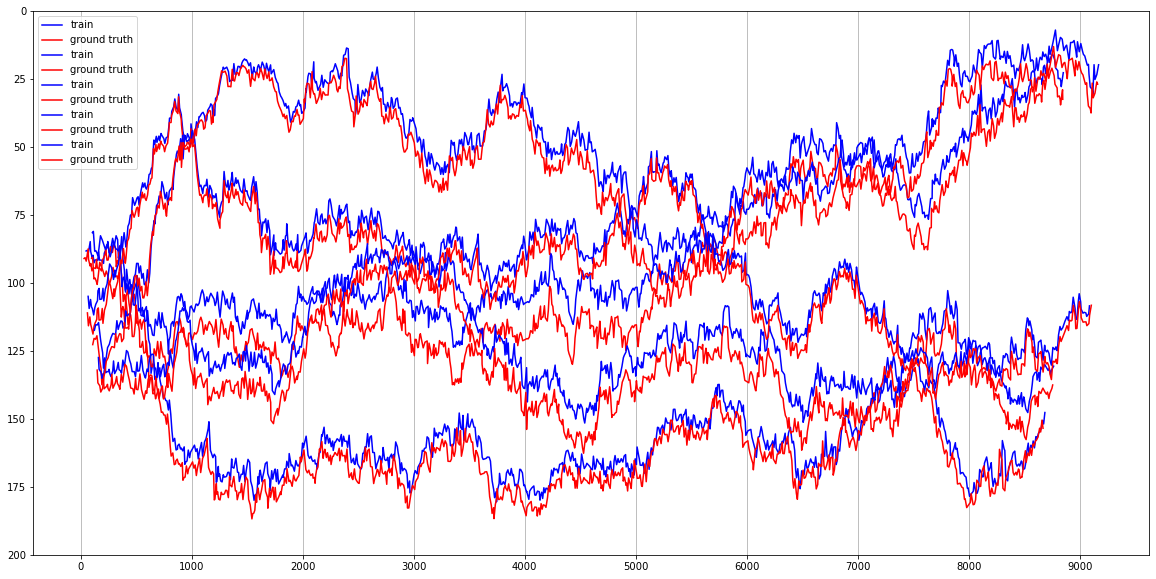

In [93]:
plot_pred(pred_centre_df, centre_ids)

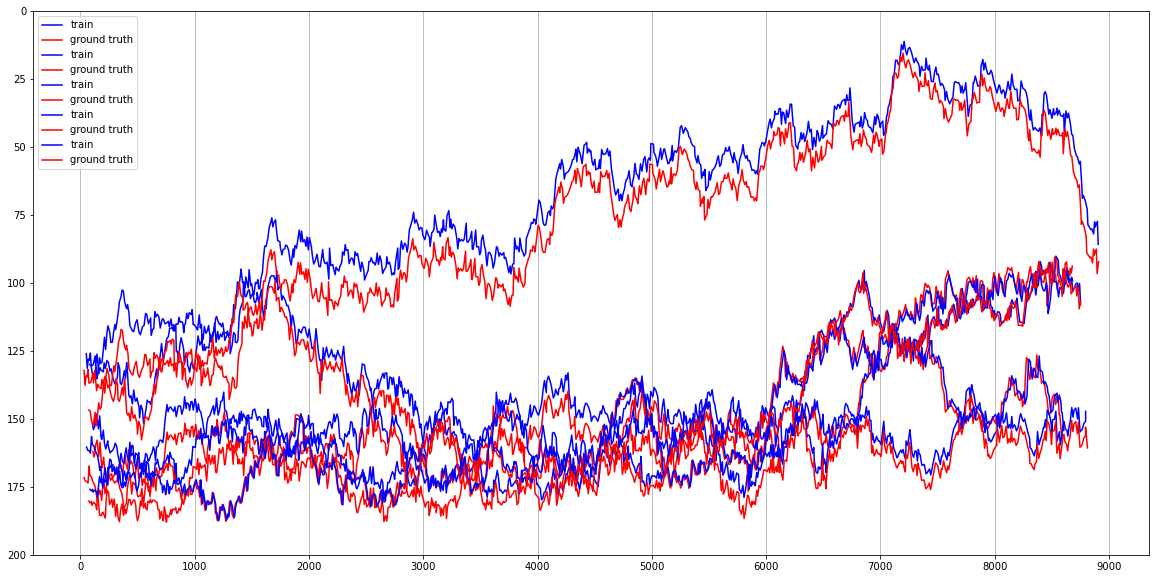

In [94]:
plot_pred(pred_bottom_df, bottom_ids)

**Train on centre**

In [95]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()
lin_model.fit(X_centre, y_centre)

LinearRegression()

In [96]:
print("The model performance for training set (centre)")
centre_pred = evaluate(X_centre, y_centre)

print("The model performance for testing set (top)")
top_pred = evaluate(X_top, y_top)

print("The model performance for testing set (bottom)")
bottom_pred = evaluate(X_bottom, y_bottom)

The model performance for training set (centre)
--------------------------------------
RMSE is 3.6086960518467164
R2 score is 0.9915238403916924


The model performance for testing set (top)
--------------------------------------
RMSE is 11.761901504967794
R2 score is 0.8922935750143198


The model performance for testing set (bottom)
--------------------------------------
RMSE is 11.146758236691758
R2 score is 0.9305108391186965




In [97]:
pred_top_df = get_pred_df_idx(top_pred, top_ids)
pred_centre_df = get_pred_df_idx(centre_pred, centre_ids)
pred_bottom_df = get_pred_df_idx(bottom_pred, bottom_ids)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 799/799 [00:07<00:00, 105.18it/s]


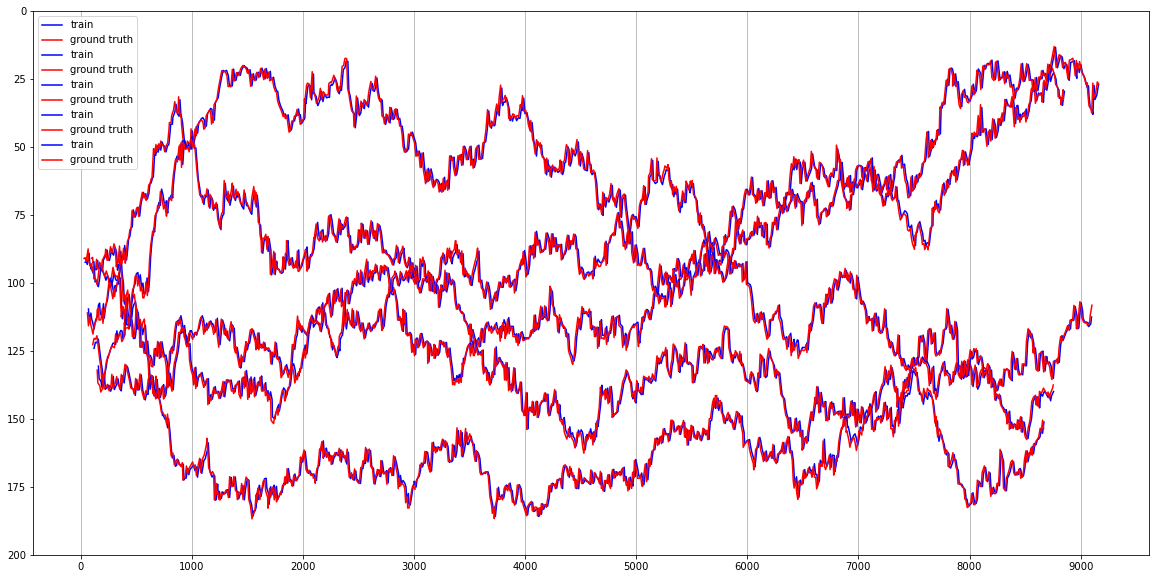

In [98]:
plot_pred(pred_centre_df, centre_ids)

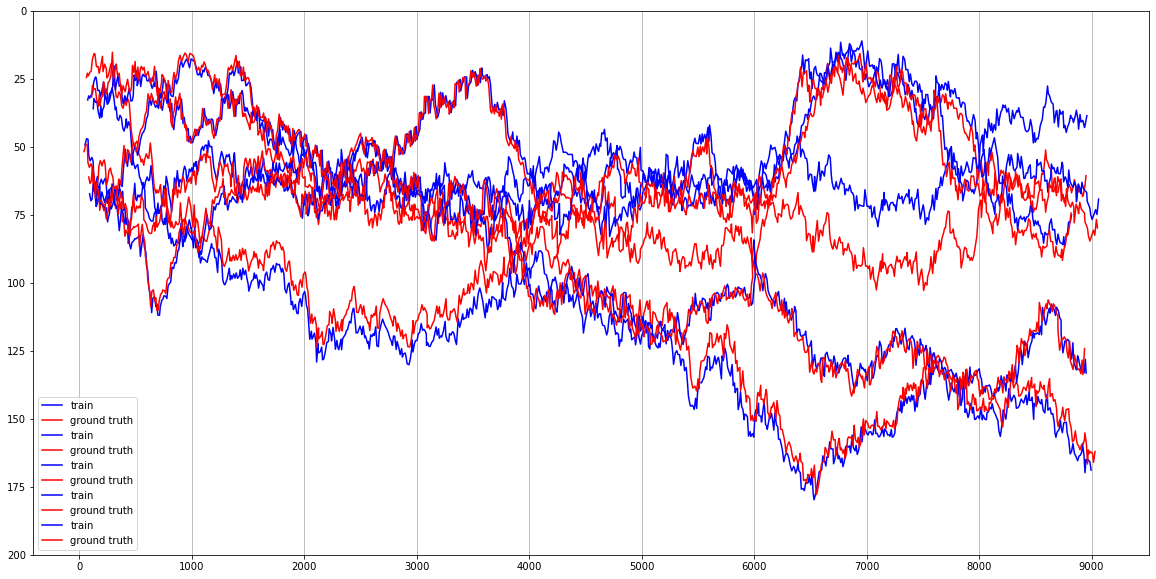

In [99]:
plot_pred(pred_top_df, top_ids)

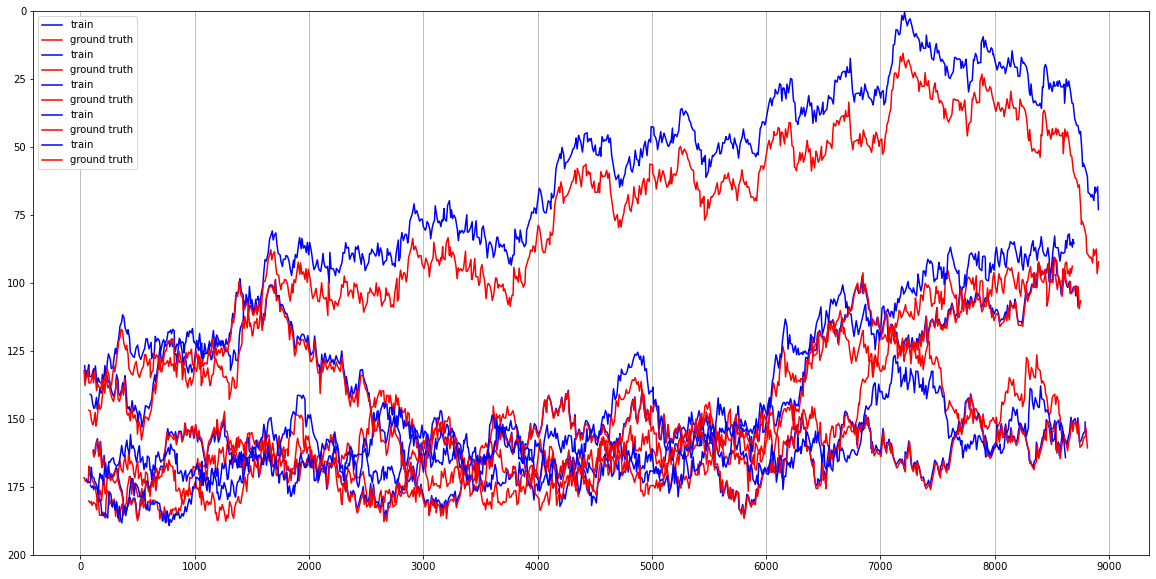

In [100]:
plot_pred(pred_bottom_df, bottom_ids)

**Train on bottom**

In [101]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()
lin_model.fit(X_bottom, X_bottom)

LinearRegression()

In [102]:
print("The model performance for training set (bottom)")
bottom_pred = evaluate(X_bottom, y_bottom)

print("The model performance for testing set (centre)")
centre_pred = evaluate(X_centre, y_centre)

print("The model performance for testing set (top)")
top_pred = evaluate(X_top, y_top)

The model performance for training set (bottom)
--------------------------------------
RMSE is 8.473243898917884
R2 score is 0.9814422797040983


The model performance for testing set (centre)
--------------------------------------
RMSE is 8.626416563199296
R2 score is 0.9911342251604113


The model performance for testing set (top)
--------------------------------------
RMSE is 8.63798663086226
R2 score is 0.9873691487229118




In [103]:
pred_top_df = get_pred_df_idx(top_pred, top_ids)
pred_centre_df = get_pred_df_idx(centre_pred, centre_ids)
pred_bottom_df = get_pred_df_idx(bottom_pred, bottom_ids)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 799/799 [00:05<00:00, 140.70it/s]


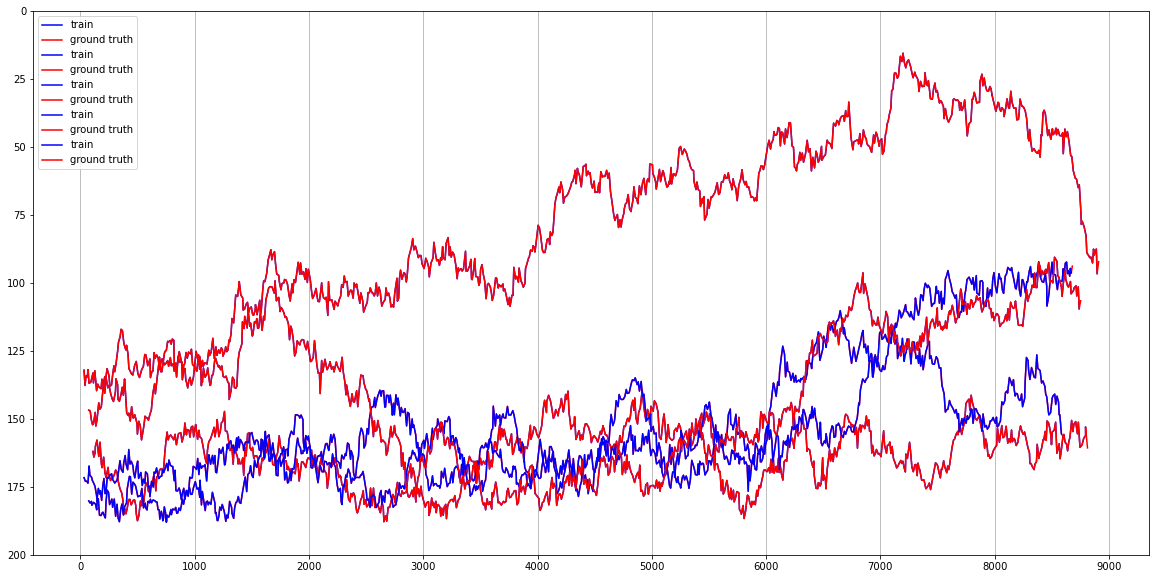

In [104]:
plot_pred(pred_bottom_df, bottom_ids)

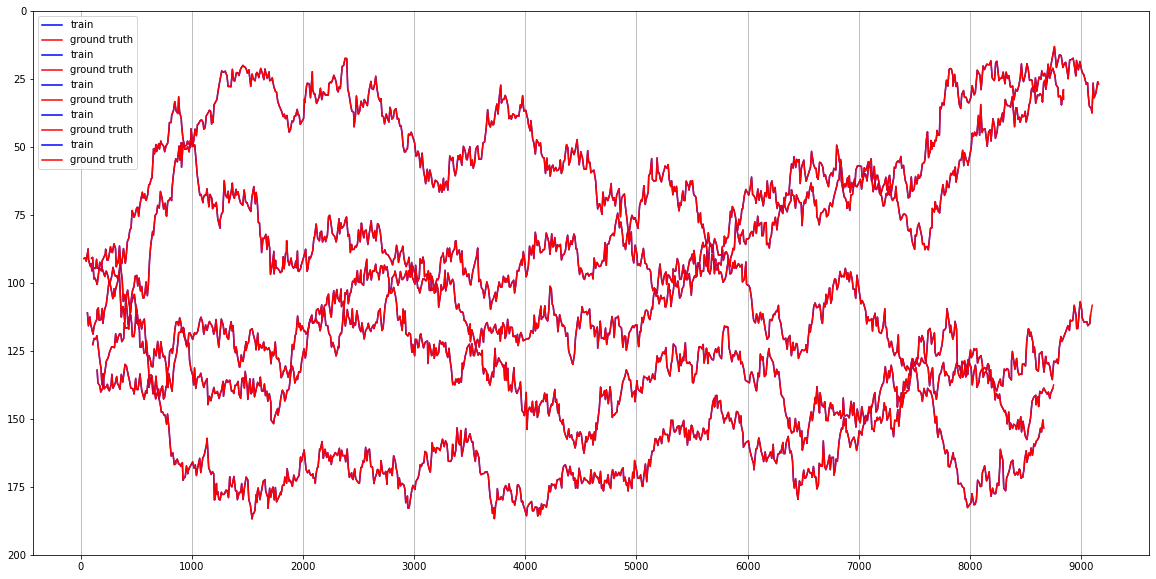

In [105]:
plot_pred(pred_centre_df, centre_ids)

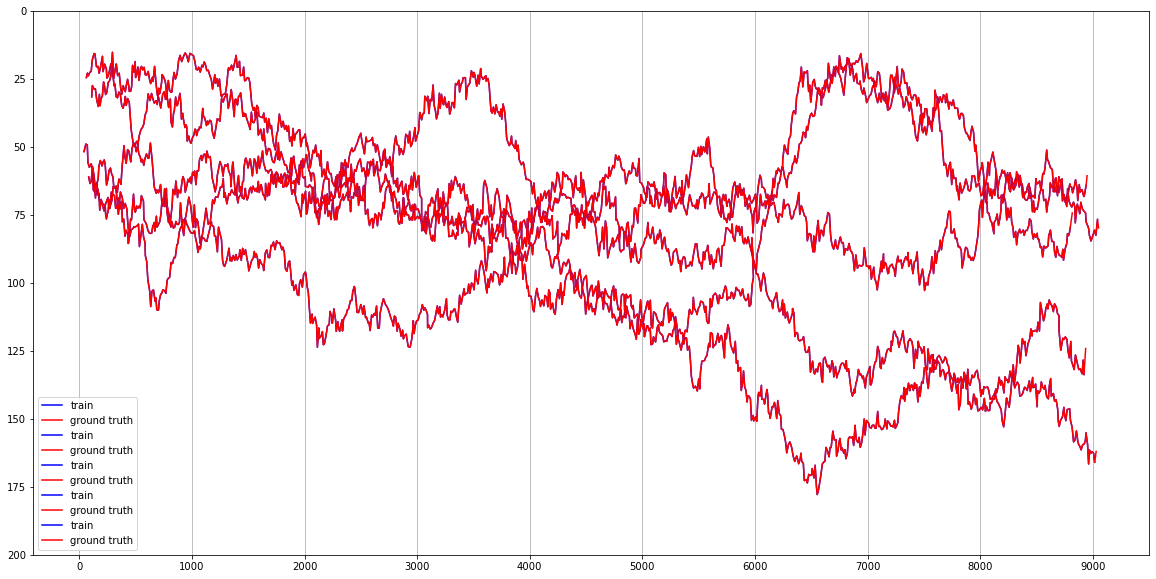

In [106]:
plot_pred(pred_top_df, top_ids)